In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os
import warnings
import requests
import tensorflow as tf
import pickle
import math

In [3]:
#importing required datasets
from google.colab import drive
import os
drive.mount('/content/drive')

data_syn = '/content/drive/My Drive/synthetic_data/synthetic/'
data_pub = '/content/drive/My Drive/public_data/public/'
data_cd =  '/content/drive/My Drive/cats_dogs/cd/'



# Useful links : 
# https://github.com/turpaultn/DESED
# https://dcase.community/challenge2019/task-sound-event-detection-in-domestic-environments#description
# Synthetic data uploaded in drive : 
# https://drive.google.com/drive/folders/1oeuUnOQzuFrCvs-OAplr6DunE4eynmM4?usp=sharing
# Domestic Public daata in drive : 
# https://drive.google.com/drive/folders/1AIMY-L8n8VcncZ60nW4FZ4_J4dCQPEml?usp=sharing

Mounted at /content/drive


In [108]:
import csv
import math
rows = []
with open("synthetic_dataset.csv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row[0])



audio_data = []
dict1={'Speech':0,'Cat': 1,'Dog':2,'Alarm_bell_ringing':3,'Dishes':4,'Frying':5,'Blender':6,'Running_water':7,'Vacuum_cleaner':8,'Electric_shaver_toothbrush':9}
for idx,i in enumerate(rows):
    print(idx, end = ' \n')
    i = i.split('\t')
    size=float(i[2])-float(i[1])
    # print(size, end = ' ')
    mult=math.ceil(2.97/size)
    # print(mult,  end = ' ')
    y1, sr = librosa.load(data_syn+i[0],offset=float(i[1]),duration=size)
    y = np.copy(y1)
    # print(len(y),end = ' ')
    for idx in range(mult-1):
      y = np.concatenate((y,y1))
    y = y[:int(2.97*sr)]
    # print(len(y),end = ' ')
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    # print(ps.shape)
    if ps.shape!=(128,128): continue
    ps=librosa.power_to_db(ps)
    audio_data.append([ps,dict1[i[3]]])




In [ ]:
print(len(audio_data))

6032


In [109]:
rows = []
with open("public.tsv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row[0])



public_data = []
dict1={'Speech':0,'Cat': 1,'Dog':2,'Alarm_bell_ringing':3,'Dishes':4,'Frying':5,'Blender':6,'Running_water':7,'Vacuum_cleaner':8,'Electric_shaver_toothbrush':9}
for idx,i in enumerate(rows):
    print(idx, end = ' \n')
    i = i.split('\t')
    size=float(i[2])-float(i[1])
    # print(size, end = ' ')
    mult=math.ceil(2.97/size)
    # print(mult,  end = ' ')
    y1, sr = librosa.load(data_pub+i[0],offset=float(i[1]),duration=size)
    y = np.copy(y1)
    # print(len(y),end = ' ')
    for idx in range(mult-1):
      y = np.concatenate((y,y1))
    y = y[:int(2.97*sr)]
    # print(len(y),end = ' ')
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    # print(ps.shape)
    if ps.shape!=(128,128): continue
    ps=librosa.power_to_db(ps)
    public_data.append([ps,dict1[i[3]]])

In [110]:
from posixpath import split
filenames1 = tf.io.gfile.glob(data_cd + '*')
cd_data = []
dict2 = {'c' : 1, 'd' : 2}
for idx,i in enumerate(filenames1):
    print(idx,  end = ' ')
    y1, sr = librosa.load(i)
    size= len(y1) / sr
    print(size, end = ' ')
    mult=math.ceil(2.97/size)
    y = np.copy(y1)
    print(len(y),end = ' ')
    for idx in range(mult-1):
      y = np.concatenate((y,y1))
    y = y[:int(2.97*sr)]
    print(len(y),end = ' ')
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    print(ps.shape)
    if ps.shape!=(128,128): continue
    ps=librosa.power_to_db(ps)
    cd_data.append([ps,dict2[i.split('/')[-1][0]]])
  

In [ ]:
with open('audio_file.pkl', 'wb') as file:
    pickle.dump(audio_data, file)

with open('public_file.pkl', 'wb') as file:
    pickle.dump(public_data, file)

with open('cd_file.pkl', 'wb') as file:
    pickle.dump(cd_data, file)

In [ ]:
!cp 'audio_file.pkl' '/content/drive/My Drive/synthetic_data/'

In [ ]:
!cp 'public_file.pkl' '/content/drive/My Drive/public_data/'

In [ ]:
!cp 'cd_file.pkl' '/content/drive/My Drive/cats_dogs/'

In [4]:

f_syn = open('/content/drive/My Drive/synthetic_data/audio_file.pkl','rb')
f_pub = open('/content/drive/My Drive/public_data/public_file.pkl','rb')
f_cd = open('/content/drive/My Drive/cats_dogs/cd_file.pkl','rb')

audio_data = pickle.load(f_syn)
public_data = pickle.load(f_pub)
cd_data = pickle.load(f_cd)


In [ ]:
print(len(audio_data))
print(len(public_data))
print(len(cd_data))

6032
2765
277


In [32]:
pre_data = audio_data+public_data
random.shuffle(pre_data)

In [33]:
final_data = []
arr = [0]*10
for a in pre_data:
  if(arr[a[1]] <= 700):
    arr[a[1]] += 1
    final_data.append(a)
    continue
  if(a[1] == 1 or a[1] == 2):
    arr[a[1]] += 1
    final_data.append(a)
  


In [34]:
print(arr)

[701, 787, 957, 701, 701, 227, 624, 266, 300, 338]


In [35]:
audio_data1 = final_data

In [36]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]

label_ct = [0]*10

def split(train,test):
    for x in train:
        X_train.append(x[0])
        y_train.append(x[1])
        label_ct[x[1]] += 1
    for y in test:
        X_test.append(y[0])
        y_test.append(y[1])
        label_ct[y[1]] += 1


            
random.shuffle(audio_data1)



train = audio_data1[:8*len(audio_data1)//10]
test = audio_data1[8*len(audio_data1)//10:]
split(train,test)


y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)


print(label_ct)

[701, 787, 957, 701, 701, 227, 624, 266, 300, 338]


In [ ]:
print(y_train)
print(y_test)

[8 2 8 ... 2 3 1]
[9 2 8 ... 3 3 3]


# Model 1

In [37]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [38]:
print(y_test.shape)

(1121,)


In [39]:
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=y_train,
    epochs=20,
    batch_size=50,
    validation_data= (X_test, y_test))

score = model.evaluate(
    x=X_test,
    y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/20
90/90 [==============================] - 2s 22ms/step - loss: 2.1448 - accuracy: 0.2328 - val_loss: 1.7037 - val_accuracy: 0.3916
Epoch 2/20
90/90 [==============================] - 2s 17ms/step - loss: 1.6596 - accuracy: 0.4399 - val_loss: 1.6942 - val_accuracy: 0.4237
Epoch 3/20
90/90 [==============================] - 2s 17ms/step - loss: 1.4461 - accuracy: 0.5287 - val_loss: 1.3933 - val_accuracy: 0.5397
Epoch 4/20
90/90 [==============================] - 2s 17ms/step - loss: 1.3111 - accuracy: 0.5831 - val_loss: 1.1844 - val_accuracy: 0.6244
Epoch 5/20
90/90 [==============================] - 2s 17ms/step - loss: 1.2049 - accuracy: 0.6229 - val_loss: 1.1842 - val_accuracy: 0.6325
Epoch 6/20
90/90 [==============================] - 2s 17ms/step - loss: 1.1145 - accuracy: 0.6536 - val_loss: 1.0139 - val_accuracy: 0.6789
Epoch 7/20
90/90 [==============================] - 2s 17ms/step - loss: 1.0437 - accuracy: 0.6811 - val_loss: 1.0490 - val_accuracy: 0.6878
Epoch 8/20
90

In [40]:
y_pred = np.argmax(model.predict(X_test),axis = 1)
print(y_test)
print(y_pred)

[0 7 0 ... 1 3 0]
[6 7 1 ... 1 3 0]


[[ 88.   9.  17.   3.   7.   0.   8.   2.   2.   3.]
 [  4. 147.   7.   1.   0.   0.   4.   1.   0.   0.]
 [  8.   1. 157.   1.   3.   0.   2.   1.   0.   0.]
 [  3.   2.   4. 118.   3.   0.   1.   0.   1.   3.]
 [ 10.   1.   9.   2. 107.   2.  11.   4.   0.   1.]
 [  6.   1.   0.   0.   5.  21.   7.   7.   0.   1.]
 [  6.   0.   2.   1.   2.   0. 101.   3.  12.   5.]
 [  6.   0.   2.   1.   4.   6.   5.  21.   0.   2.]
 [  2.   1.   2.   1.   1.   0.  23.   4.  30.   1.]
 [  0.   0.   0.   4.   0.   3.  11.   0.   2.  51.]]


Text(0.5, 1.05, 'CONFUSION MATRIX')

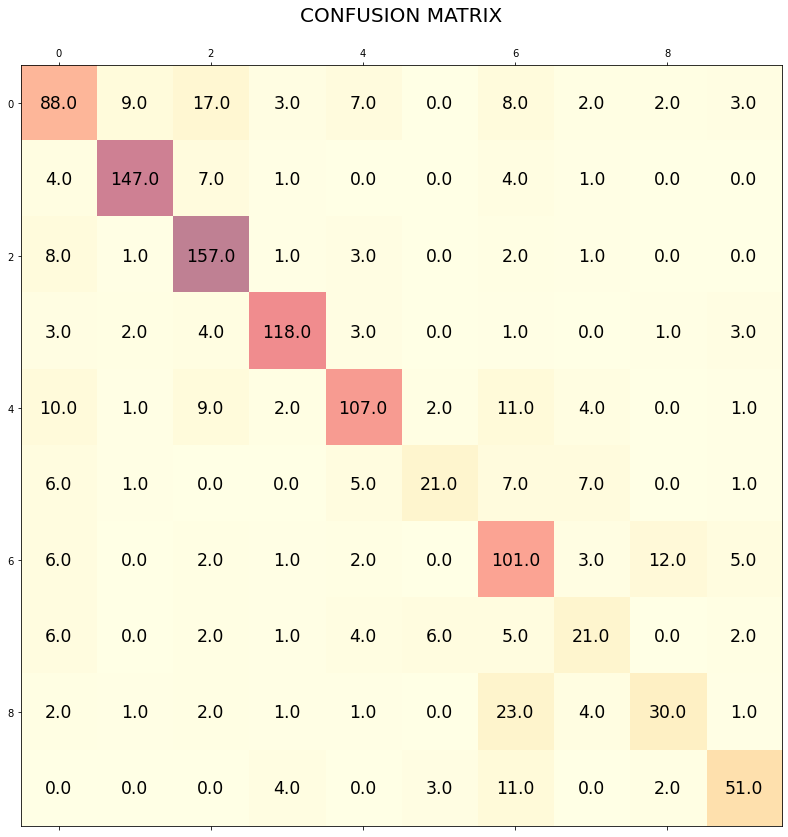

In [41]:
conf_mat = np.zeros((10,10))
for idx,i in enumerate(range(len(y_pred))):
  conf_mat[y_test[idx],y_pred[idx]] += 1
print(conf_mat)

import matplotlib.pyplot as plt
fig, px = plt.subplots(figsize=(20, 14))
px.matshow(conf_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for i1 in range(conf_mat.shape[0]):
  for j1 in range(conf_mat.shape[1]):
    px.text(x=j1,y=i1,s=conf_mat[i1, j1], va='center', ha='center', size='xx-large')
px.set_title("CONFUSION MATRIX", fontsize = 20)

Text(0.5, 1.05, 'CONFUSION MATRIX')

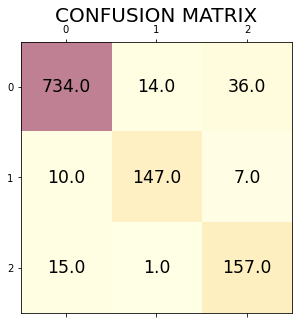

In [42]:
conf_mat1 = np.zeros((3,3))
for idx,i in enumerate(range(len(y_pred))):
  ii = y_test[idx]
  jj = y_pred[idx]
  if (ii == 1 or ii == 2): pass
  else: ii = 0
  if (jj == 1 or jj == 2): pass
  else: jj = 0
  conf_mat1[ii,jj] += 1




import matplotlib.pyplot as plt
fig, px = plt.subplots(figsize=(10, 5))
px.matshow(conf_mat1, cmap=plt.cm.YlOrRd, alpha=0.5)
for i1 in range(conf_mat1.shape[0]):
  for j1 in range(conf_mat1.shape[1]):
    px.text(x=j1,y=i1,s=conf_mat1[i1, j1], va='center', ha='center', size='xx-large')
px.set_title("CONFUSION MATRIX", fontsize = 20)

In [43]:
sm = np.sum(conf_mat1) 
acc = 1 - ((sm - np.sum(np.diag(conf_mat1)))/sm)
print(acc)

0.9259589652096343


# Model 2

In [44]:
model1 = Sequential()
input_shape=(128, 128, 1)

model1.add(Conv2D(48, (5, 5), strides=(1, 1), input_shape=input_shape))
model1.add(MaxPooling2D((4, 2), strides=(4, 2)))
model1.add(LeakyReLU(alpha=0.1))

model1.add(Conv2D(64, (5, 5), padding="valid"))
model1.add(MaxPooling2D((4, 2), strides=(4, 2)))
model1.add(LeakyReLU(alpha=0.1))

model1.add(Conv2D(64, (5, 5), padding="valid"))
model1.add(LeakyReLU(alpha=0.1))

model1.add(Flatten())
model1.add(Dropout(rate=0.5))

model1.add(Dense(128))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Dropout(rate=0.5))

model1.add(Dense(10))
model1.add(Activation('softmax'))

In [45]:
model1.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])

model1.fit(
    x=X_train, 
    y=y_train,
    epochs=20,
    batch_size=50,
    validation_data= (X_test, y_test))

score1 = model1.evaluate(
    x=X_test,
    y=y_test)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])


Epoch 1/20
90/90 [==============================] - 3s 29ms/step - loss: 2.3203 - accuracy: 0.3111 - val_loss: 1.4870 - val_accuracy: 0.4871
Epoch 2/20
90/90 [==============================] - 2s 24ms/step - loss: 1.4599 - accuracy: 0.5296 - val_loss: 1.2196 - val_accuracy: 0.6146
Epoch 3/20
90/90 [==============================] - 2s 22ms/step - loss: 1.2570 - accuracy: 0.5967 - val_loss: 1.0520 - val_accuracy: 0.6655
Epoch 4/20
90/90 [==============================] - 2s 22ms/step - loss: 1.1536 - accuracy: 0.6322 - val_loss: 1.0666 - val_accuracy: 0.6619
Epoch 5/20
90/90 [==============================] - 2s 23ms/step - loss: 1.0836 - accuracy: 0.6525 - val_loss: 1.0111 - val_accuracy: 0.6744
Epoch 6/20
90/90 [==============================] - 2s 22ms/step - loss: 0.9582 - accuracy: 0.6927 - val_loss: 0.9095 - val_accuracy: 0.7074
Epoch 7/20
90/90 [==============================] - 2s 22ms/step - loss: 0.9130 - accuracy: 0.7034 - val_loss: 0.8600 - val_accuracy: 0.7467
Epoch 8/20
90

In [46]:
y_pred = np.argmax(model1.predict(X_test),axis = 1)

[[116.   2.   6.   2.   4.   2.   1.   0.   2.   4.]
 [  4. 150.   7.   0.   3.   0.   0.   0.   0.   0.]
 [ 10.   9. 148.   0.   5.   0.   0.   0.   1.   0.]
 [  4.   5.   3. 119.   3.   0.   0.   0.   0.   1.]
 [ 16.   1.   8.   4. 109.   3.   3.   2.   0.   1.]
 [  8.   0.   1.   0.   8.  21.   4.   5.   0.   1.]
 [  8.   0.   0.   0.   5.   0.  99.   6.   6.   8.]
 [  5.   0.   0.   1.   8.   3.   0.  29.   0.   1.]
 [  5.   3.   4.   0.   0.   5.  14.   6.  24.   4.]
 [  2.   0.   0.   3.   0.   4.   3.   4.   0.  55.]]


Text(0.5, 1.05, 'CONFUSION MATRIX')

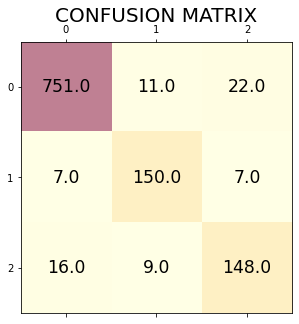

In [47]:
conf_mat = np.zeros((10,10))
for idx,i in enumerate(range(len(y_pred))):
  conf_mat[y_test[idx],y_pred[idx]] += 1
print(conf_mat)

conf_mat1 = np.zeros((3,3))
for idx,i in enumerate(range(len(y_pred))):
  ii = y_test[idx]
  jj = y_pred[idx]
  if (ii == 1 or ii == 2): pass
  else: ii = 0
  if (jj == 1 or jj == 2): pass
  else: jj = 0
  conf_mat1[ii,jj] += 1




import matplotlib.pyplot as plt
fig, px = plt.subplots(figsize=(10, 5))
px.matshow(conf_mat1, cmap=plt.cm.YlOrRd, alpha=0.5)
for i1 in range(conf_mat1.shape[0]):
  for j1 in range(conf_mat1.shape[1]):
    px.text(x=j1,y=i1,s=conf_mat1[i1, j1], va='center', ha='center', size='xx-large')
px.set_title("CONFUSION MATRIX", fontsize = 20)

In [48]:
sm = np.sum(conf_mat1) 
acc = 1 - ((sm - np.sum(np.diag(conf_mat1)))/sm)
print(acc)

0.935771632471008


In [56]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [111]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

!rm recording.wav

if os.path.isfile('recording1.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
else:
    print("Recording the digits")
    wav = record(3) 
    wav = wav.set_frame_rate(22050)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 22050, fp_arr) 

Recording the digits


<IPython.core.display.Javascript object>

In [112]:
y1, sr = librosa.load('recording.wav')
num = 65488
px = np.zeros(max(0,num-len(y1)))
y1 = np.concatenate((px,y1))

print(len(y1),sr)

ps = librosa.feature.melspectrogram(y=y1,sr=sr)
ps = librosa.power_to_db(ps)
ps = ps.reshape((1,128,128))
print(ps.shape)


y_pred = np.argmax(model.predict(ps),axis = 1)
if(y_pred==1):
  print('cat')
elif(y_pred == 2):
  print('dog')
else:
  print('other sound')

y_pred1 = np.argmax(model1.predict(ps),axis = 1)
if(y_pred1==1):
  print('cat')
elif(y_pred1 == 2):
  print('dog')
else:
  print('other sound')

65488 22050
(1, 128, 128)
other sound
cat
